# Module 1: Disaster Frequency Time Series Analysis

Fitting SARIMA and Prophet models to monthly national disaster counts.  
Evaluating forecast accuracy and projecting 3-5 years forward.

**Prerequisites:** Run `python src/models/disaster_time_series.py` first to generate model outputs.

In [1]:
import sys
sys.path.insert(0, "..")

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from src.utils.config import DATA_PROCESSED, REPORTS_FIGURES, MODELS_DIR, FORECAST_HORIZON_YEARS
from src.models.disaster_time_series import (
    prepare_national_time_series,
    train_test_split_temporal,
    test_stationarity,
)

REPORTS_FIGURES.mkdir(parents=True, exist_ok=True)

plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["figure.dpi"] = 100
sns.set_theme(style="whitegrid")

print("Setup complete.")

Setup complete.


## 1. Load & Visualize Raw Time Series

2026-02-15 19:33:19,139 INFO Train: 2004-01-01 to 2022-12-01 (228 months)
2026-02-15 19:33:19,140 INFO Test:  2023-01-01 to 2024-12-01 (24 months)


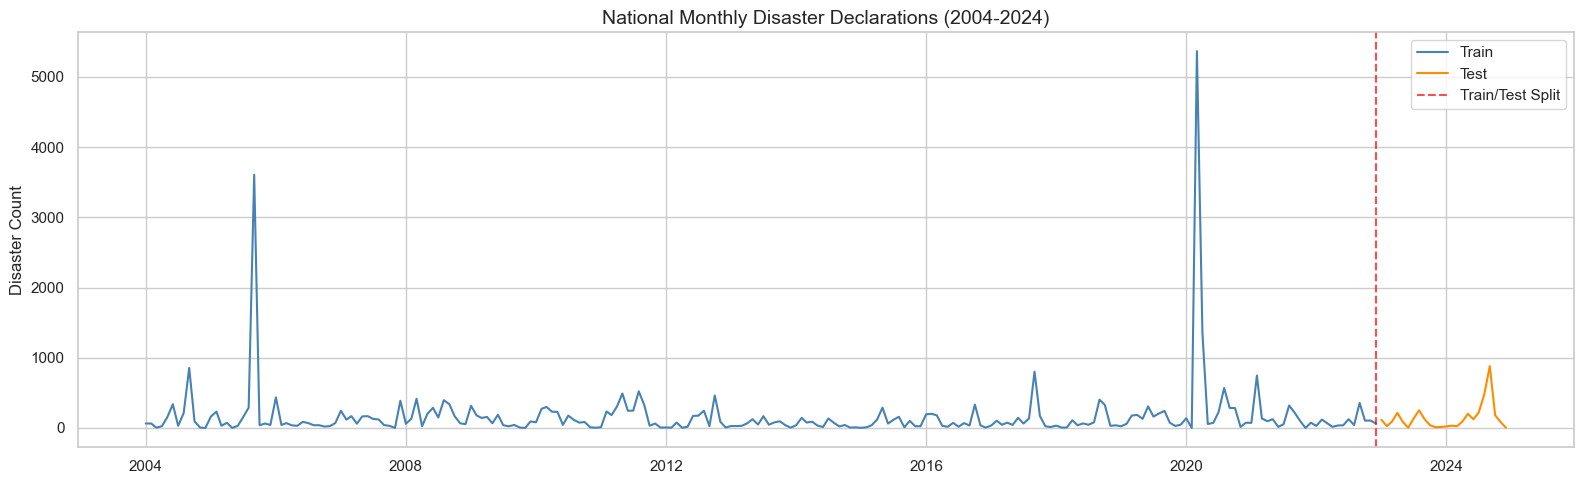


Time series length: 252 months
Train: 228 months | Test: 24 months
Mean monthly disasters: 164.1
Std: 427.1


In [2]:
ts = prepare_national_time_series()
train, test = train_test_split_temporal(ts, test_months=24)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(train["date"], train["disaster_count"], label="Train", color="steelblue")
ax.plot(test["date"], test["disaster_count"], label="Test", color="darkorange")
ax.axvline(
    x=train["date"].max(), color="red", linestyle="--", alpha=0.7,
    label="Train/Test Split",
)
ax.set_title("National Monthly Disaster Declarations (2004-2024)", fontsize=14)
ax.set_ylabel("Disaster Count")
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nTime series length: {len(ts)} months")
print(f"Train: {len(train)} months | Test: {len(test)} months")
print(f"Mean monthly disasters: {ts['disaster_count'].mean():.1f}")
print(f"Std: {ts['disaster_count'].std():.1f}")

## 2. Seasonal Decomposition

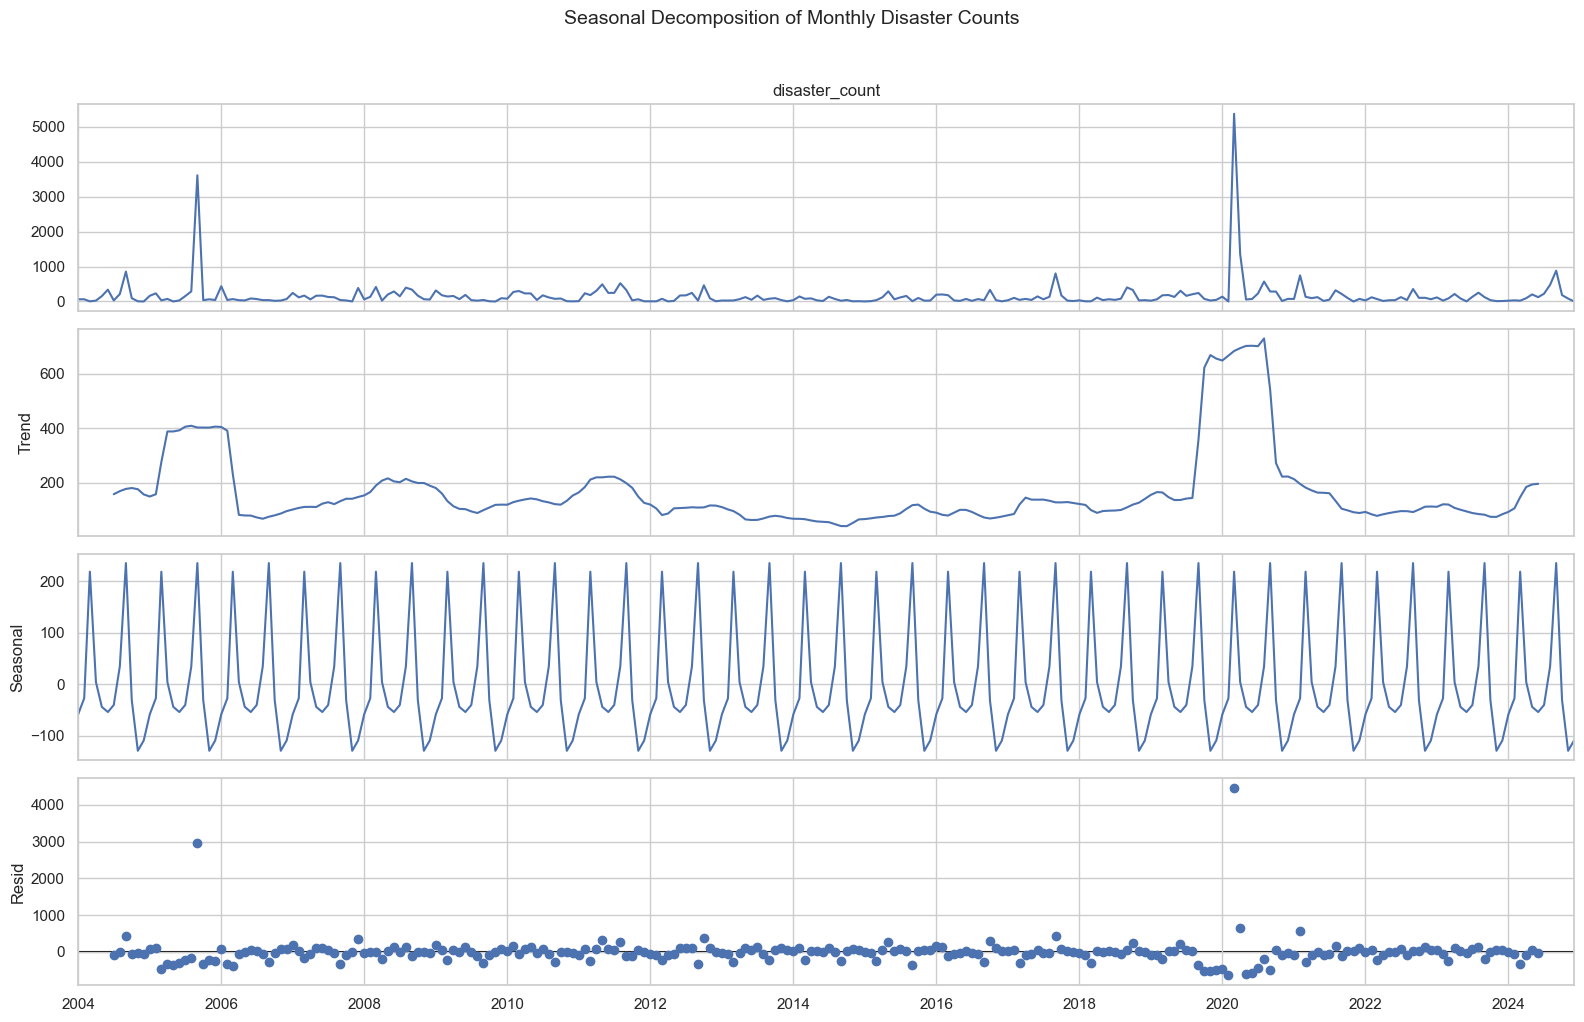

In [3]:
ts_indexed = ts.set_index("date")
decomposition = seasonal_decompose(
    ts_indexed["disaster_count"], model="additive", period=12
)

fig = decomposition.plot()
fig.set_size_inches(16, 10)
fig.suptitle(
    "Seasonal Decomposition of Monthly Disaster Counts",
    y=1.02, fontsize=14,
)
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "seasonal_decomposition.png", bbox_inches="tight")
plt.show()

## 3. Stationarity Tests

In [4]:
# Test raw series
raw_result = test_stationarity(train["disaster_count"], "Raw Series")

# First-differenced
diff1 = train["disaster_count"].diff().dropna()
diff_result = test_stationarity(diff1, "First Differenced")

# Seasonally differenced
seasonal_diff = train["disaster_count"].diff(12).dropna()
sdiff_result = test_stationarity(seasonal_diff, "Seasonally Differenced (lag=12)")

print("\n" + "=" * 50)
print("STATIONARITY SUMMARY")
print("=" * 50)
for r in [raw_result, diff_result, sdiff_result]:
    status = "Stationary" if r["is_stationary"] else "NON-stationary"
    print(f"  {r['name']:35s} p={r['p_value']:.4f}  ->  {status}")

2026-02-15 19:33:20,313 INFO ADF Test for 'Raw Series':
2026-02-15 19:33:20,313 INFO   Test Statistic: -12.9655
2026-02-15 19:33:20,314 INFO   p-value: 0.0000
2026-02-15 19:33:20,314 INFO   Stationary (p<0.05): True
2026-02-15 19:33:20,319 INFO ADF Test for 'First Differenced':
2026-02-15 19:33:20,319 INFO   Test Statistic: -7.9269
2026-02-15 19:33:20,320 INFO   p-value: 0.0000
2026-02-15 19:33:20,320 INFO   Stationary (p<0.05): True
2026-02-15 19:33:20,323 INFO ADF Test for 'Seasonally Differenced (lag=12)':
2026-02-15 19:33:20,323 INFO   Test Statistic: -6.8126
2026-02-15 19:33:20,323 INFO   p-value: 0.0000
2026-02-15 19:33:20,323 INFO   Stationary (p<0.05): True



STATIONARITY SUMMARY
  Raw Series                          p=0.0000  ->  Stationary
  First Differenced                   p=0.0000  ->  Stationary
  Seasonally Differenced (lag=12)     p=0.0000  ->  Stationary


## 4. ACF / PACF Plots

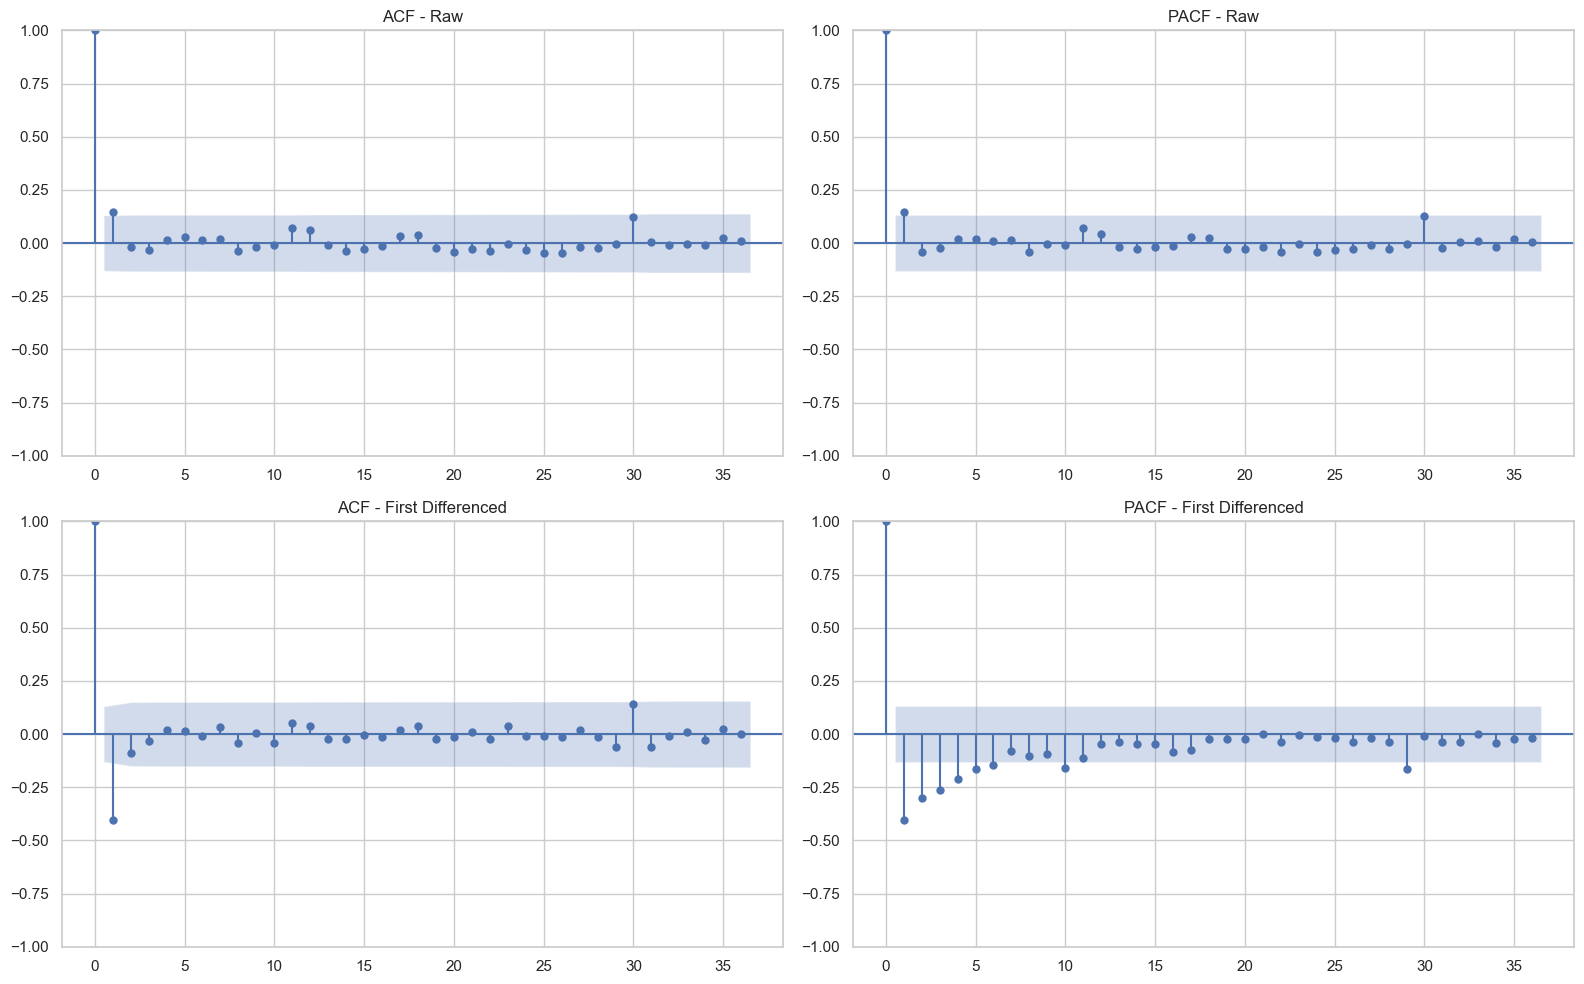

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

plot_acf(train["disaster_count"], lags=36, ax=axes[0, 0], title="ACF - Raw")
plot_pacf(train["disaster_count"], lags=36, ax=axes[0, 1], title="PACF - Raw")
plot_acf(diff1, lags=36, ax=axes[1, 0], title="ACF - First Differenced")
plot_pacf(diff1, lags=36, ax=axes[1, 1], title="PACF - First Differenced")

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "acf_pacf_plots.png", bbox_inches="tight")
plt.show()

## 5. SARIMA Grid Search Results

In [6]:
grid_results = pd.read_csv(DATA_PROCESSED / "sarima_grid_search_results.csv")
print(f"Total configurations tested: {len(grid_results)}")
print(f"\nTop 10 SARIMA configurations by AIC:")
print(grid_results.head(10).to_string(index=False))

print(f"\nBest: {grid_results.iloc[0]['order']} x {grid_results.iloc[0]['seasonal_order']}")
print(f"AIC: {grid_results.iloc[0]['aic']:.2f}")

Total configurations tested: 144

Top 10 SARIMA configurations by AIC:
    order seasonal_order         aic         bic
(0, 1, 2)  (0, 1, 1, 12) 3028.190600 3041.383869
(0, 1, 2)  (1, 1, 1, 12) 3029.949648 3046.441235
(1, 1, 2)  (0, 1, 1, 12) 3030.074028 3046.565615
(1, 1, 2)  (1, 1, 1, 12) 3031.886102 3051.676006
(2, 1, 2)  (0, 1, 1, 12) 3031.900010 3051.689914
(2, 1, 2)  (1, 1, 1, 12) 3033.555938 3056.644159
(0, 0, 2)  (0, 1, 1, 12) 3037.733840 3050.947060
(0, 0, 2)  (1, 1, 1, 12) 3039.376932 3055.893457
(1, 0, 2)  (0, 1, 1, 12) 3039.673716 3056.190241
(1, 0, 2)  (1, 1, 1, 12) 3041.376616 3061.196446

Best: (0, 1, 2) x (0, 1, 1, 12)
AIC: 3028.19


## 6. SARIMA Model Diagnostics

In [7]:
with open(MODELS_DIR / "sarima_best.pkl", "rb") as f:
    sarima_results = pickle.load(f)

print(sarima_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       disaster_count   No. Observations:                  228
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1510.095
Date:                              Sun, 15 Feb 2026   AIC                           3028.191
Time:                                      19:33:20   BIC                           3041.384
Sample:                                           0   HQIC                          3033.530
                                              - 228                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8185      0.107     -7.673      0.000      -1.028      -0.609
ma.L2         -0.15

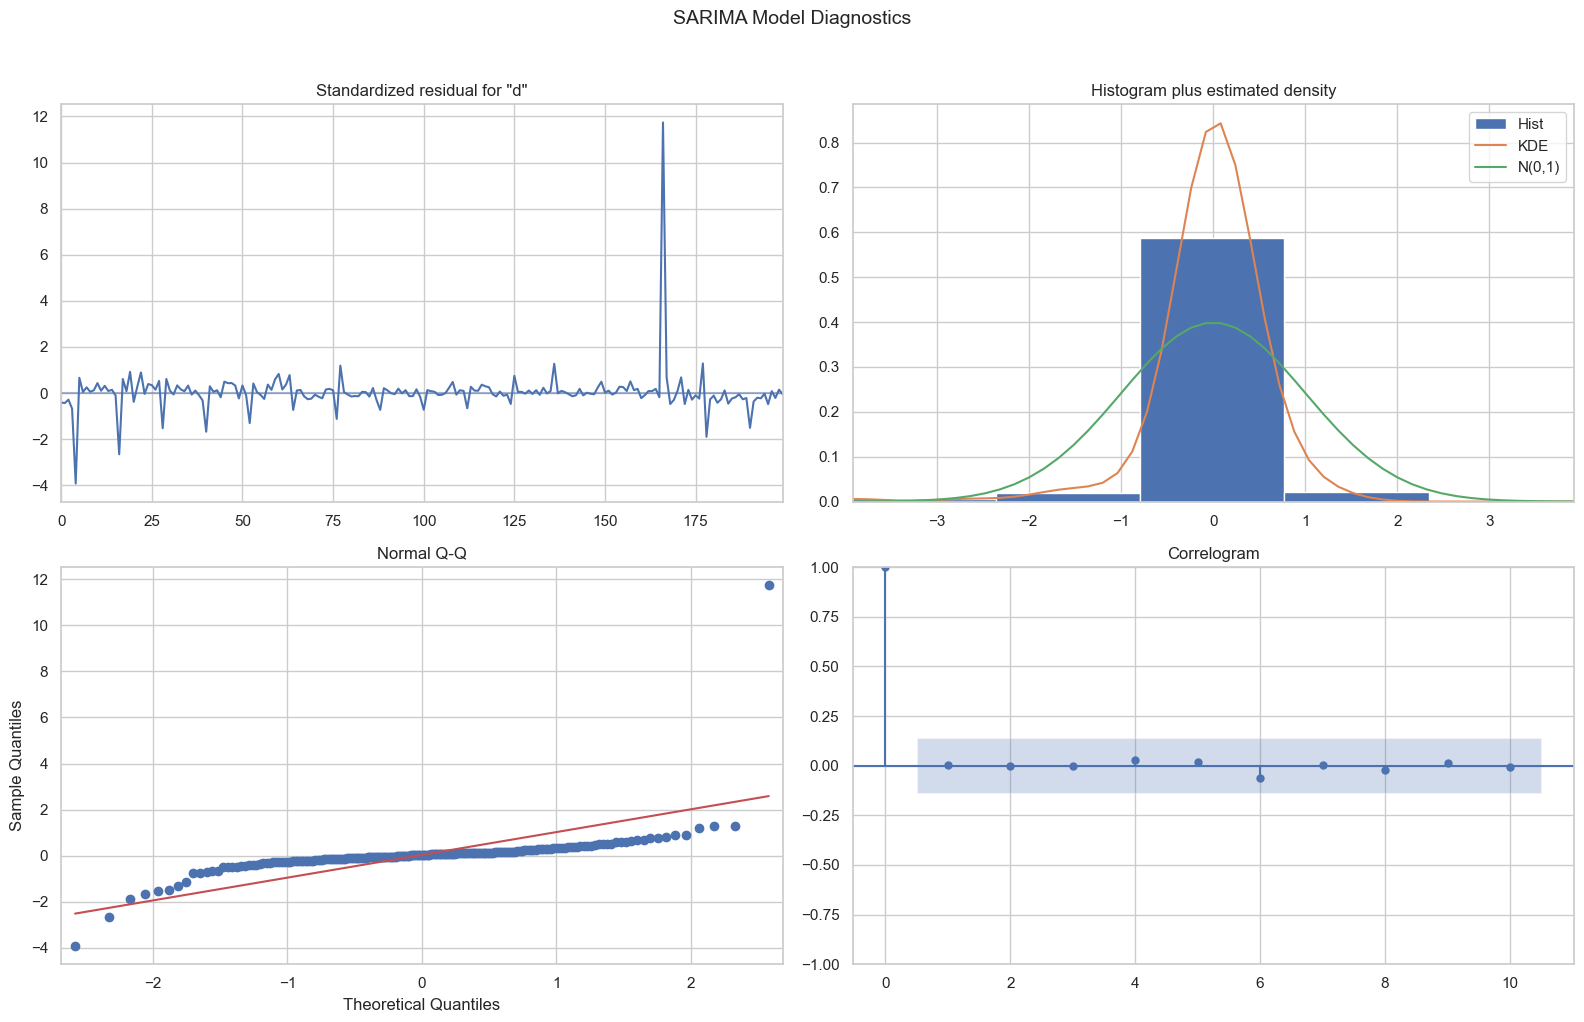

In [8]:
fig = sarima_results.plot_diagnostics(figsize=(16, 10))
fig.suptitle("SARIMA Model Diagnostics", y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "sarima_diagnostics.png", bbox_inches="tight")
plt.show()

## 7. SARIMA vs Prophet: Test Period Comparison

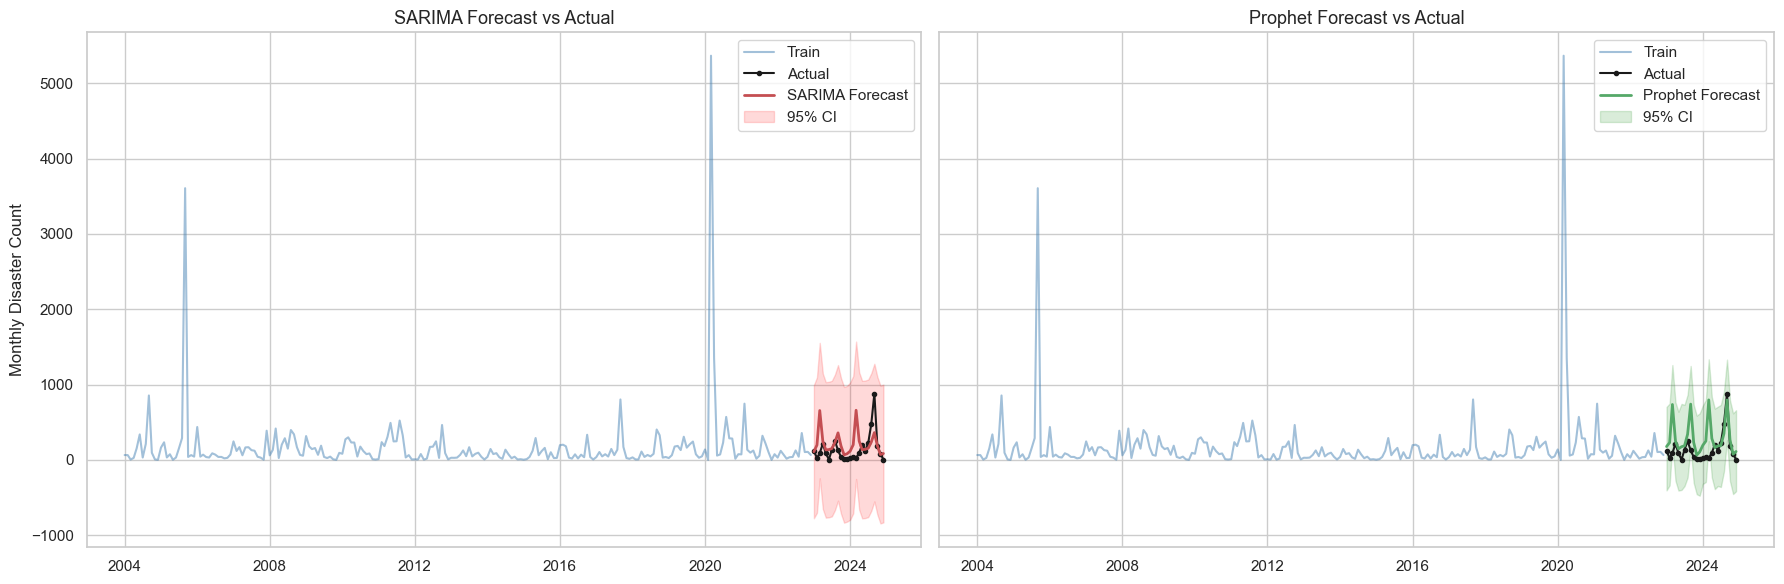

In [9]:
sarima_fc = pd.read_csv(
    DATA_PROCESSED / "sarima_test_forecast.csv", parse_dates=["date"]
)
prophet_fc = pd.read_csv(
    DATA_PROCESSED / "prophet_test_forecast.csv", parse_dates=["date"]
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# SARIMA
axes[0].plot(
    train["date"], train["disaster_count"],
    color="steelblue", alpha=0.5, label="Train",
)
axes[0].plot(
    sarima_fc["date"], sarima_fc["actual"],
    "ko-", markersize=3, label="Actual",
)
axes[0].plot(
    sarima_fc["date"], sarima_fc["forecast"],
    "r-", linewidth=2, label="SARIMA Forecast",
)
axes[0].fill_between(
    sarima_fc["date"], sarima_fc["lower_ci"], sarima_fc["upper_ci"],
    color="red", alpha=0.15, label="95% CI",
)
axes[0].set_title("SARIMA Forecast vs Actual", fontsize=13)
axes[0].set_ylabel("Monthly Disaster Count")
axes[0].legend()

# Prophet
axes[1].plot(
    train["date"], train["disaster_count"],
    color="steelblue", alpha=0.5, label="Train",
)
axes[1].plot(
    prophet_fc["date"], prophet_fc["actual"],
    "ko-", markersize=3, label="Actual",
)
axes[1].plot(
    prophet_fc["date"], prophet_fc["forecast"],
    "g-", linewidth=2, label="Prophet Forecast",
)
axes[1].fill_between(
    prophet_fc["date"], prophet_fc["lower_ci"], prophet_fc["upper_ci"],
    color="green", alpha=0.15, label="95% CI",
)
axes[1].set_title("Prophet Forecast vs Actual", fontsize=13)
axes[1].legend()

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "sarima_vs_prophet_test.png", bbox_inches="tight")
plt.show()

## 8. Model Comparison Metrics

Cross-Validated Model Comparison (5-fold TimeSeriesSplit):
          SARIMA     Prophet
rmse  374.761894  955.701786
mae   177.733995  420.845506
mape  333.562967  787.814181


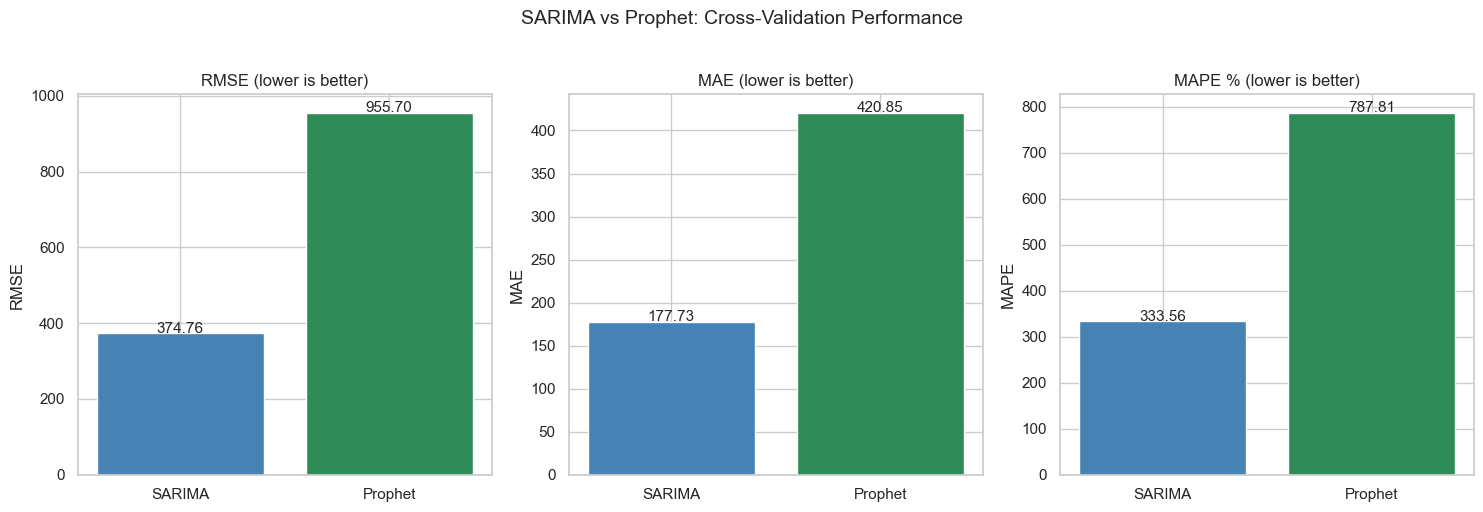

In [10]:
comparison = pd.read_csv(DATA_PROCESSED / "model_comparison.csv", index_col=0)
print("Cross-Validated Model Comparison (5-fold TimeSeriesSplit):")
print("=" * 50)
print(comparison.to_string())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = ["rmse", "mae", "mape"]
titles = ["RMSE (lower is better)", "MAE (lower is better)", "MAPE % (lower is better)"]

for ax, metric, title in zip(axes, metrics, titles):
    values = comparison.loc[metric]
    bars = ax.bar(values.index, values.values, color=["steelblue", "seagreen"])
    ax.set_title(title, fontsize=12)
    ax.set_ylabel(metric.upper())
    for bar, val in zip(bars, values.values):
        ax.text(
            bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            f"{val:.2f}", ha="center", fontsize=11,
        )

plt.suptitle("SARIMA vs Prophet: Cross-Validation Performance", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "model_comparison.png", bbox_inches="tight")
plt.show()

## 9. Future Forecast Visualization

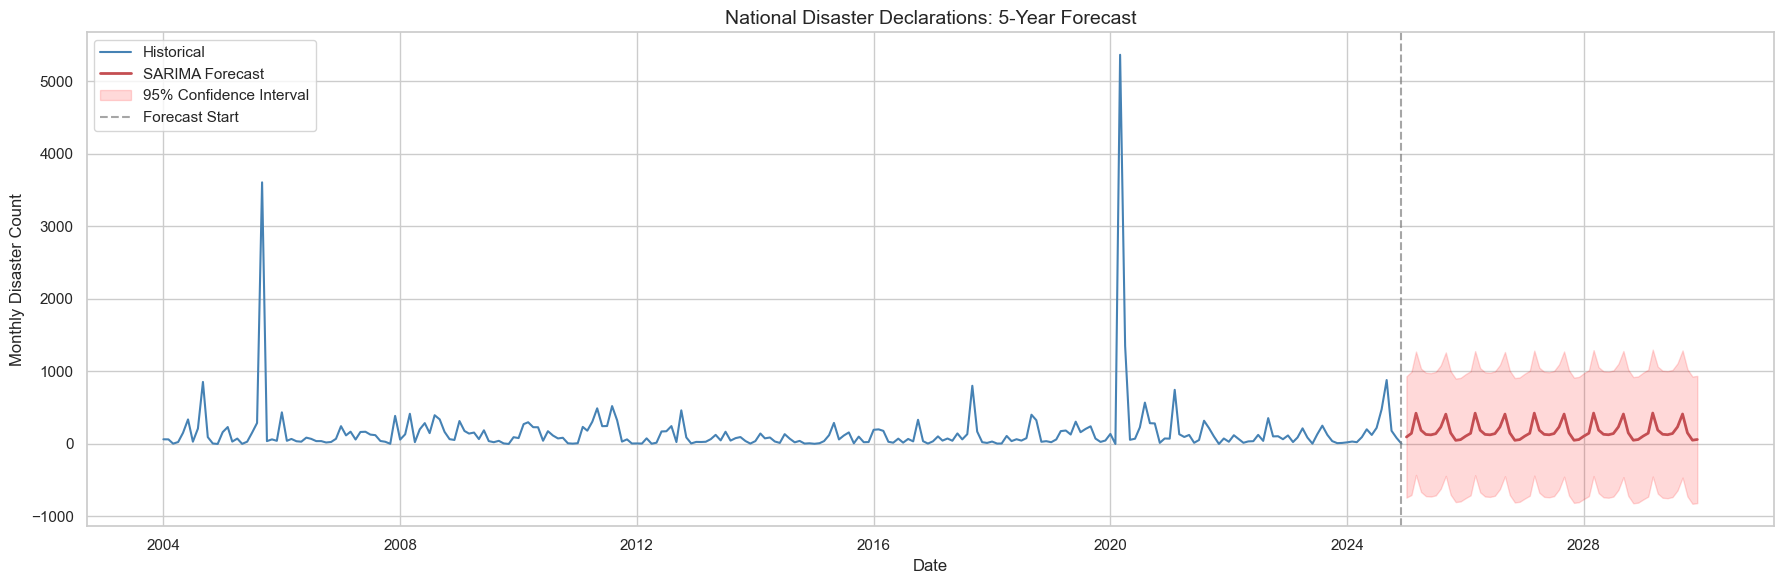


Forecast period: 2025-01-01 to 2029-12-01
Avg forecasted monthly disasters: 181.5
Historical avg: 164.1
Projected annual avg: 2177


In [11]:
future_fc = pd.read_csv(
    DATA_PROCESSED / "disaster_forecast_future.csv", parse_dates=["date"]
)

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(
    ts["date"], ts["disaster_count"],
    color="steelblue", label="Historical", linewidth=1.5,
)
ax.plot(
    future_fc["date"], future_fc["forecast"],
    "r-", linewidth=2, label="SARIMA Forecast",
)
ax.fill_between(
    future_fc["date"], future_fc["lower_ci"], future_fc["upper_ci"],
    color="red", alpha=0.15, label="95% Confidence Interval",
)
ax.axvline(
    x=ts["date"].max(), color="gray", linestyle="--", alpha=0.7,
    label="Forecast Start",
)
ax.set_title(
    f"National Disaster Declarations: {FORECAST_HORIZON_YEARS}-Year Forecast",
    fontsize=14,
)
ax.set_ylabel("Monthly Disaster Count")
ax.set_xlabel("Date")
ax.legend(loc="upper left")
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "future_forecast.png", bbox_inches="tight")
plt.show()

# Summary stats of forecast
print(f"\nForecast period: {future_fc['date'].min().date()} to {future_fc['date'].max().date()}")
print(f"Avg forecasted monthly disasters: {future_fc['forecast'].mean():.1f}")
print(f"Historical avg: {ts['disaster_count'].mean():.1f}")
print(f"Projected annual avg: {future_fc['forecast'].sum() / FORECAST_HORIZON_YEARS:.0f}")

## 10. Per-Disaster-Type Trends

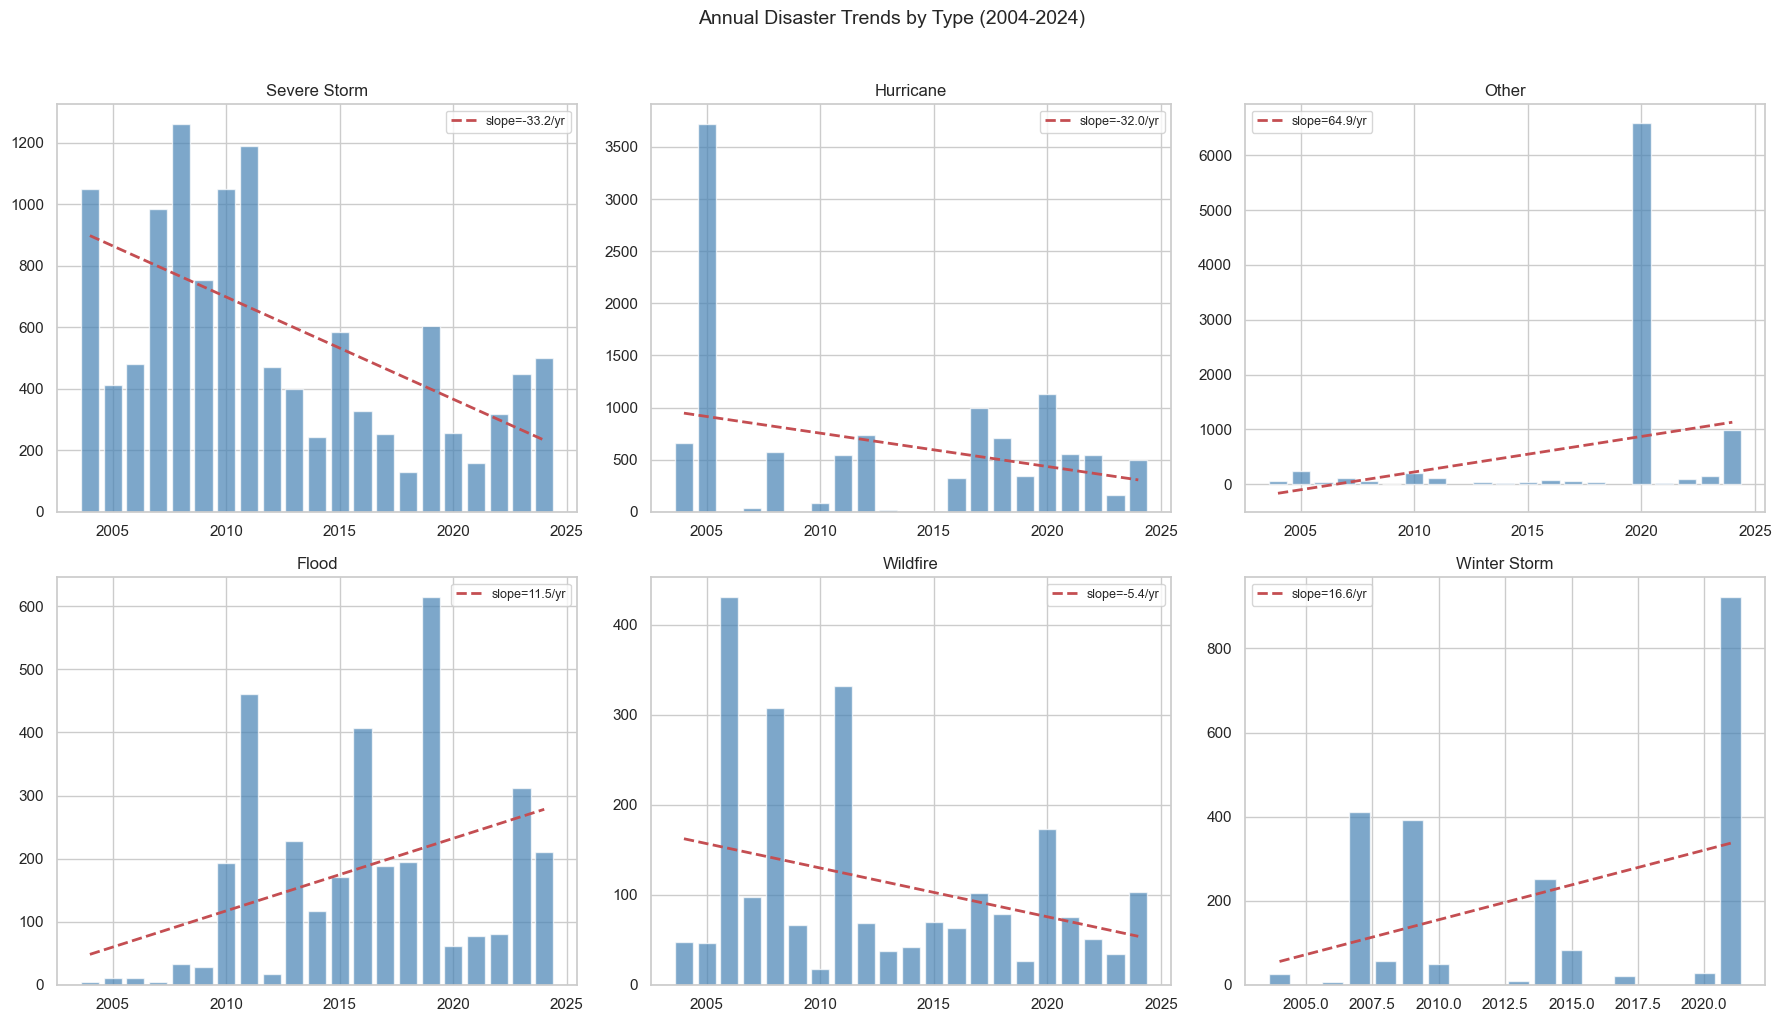

In [12]:
national_monthly = pd.read_csv(
    DATA_PROCESSED / "disasters_national_monthly.csv", parse_dates=["date"]
)

# Annual totals by type
annual_by_type = (
    national_monthly.groupby(["year", "disaster_category"])["disaster_count"]
    .sum()
    .reset_index()
)

# Top 6 disaster types
top_types = (
    annual_by_type.groupby("disaster_category")["disaster_count"]
    .sum()
    .sort_values(ascending=False)
    .head(6)
    .index
)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, dtype in enumerate(top_types):
    data = annual_by_type[annual_by_type["disaster_category"] == dtype]
    axes[i].bar(data["year"], data["disaster_count"], color="steelblue", alpha=0.7)
    
    # Add trendline
    z = np.polyfit(data["year"], data["disaster_count"], 1)
    axes[i].plot(
        data["year"], np.polyval(z, data["year"]),
        "r--", linewidth=2, label=f"slope={z[0]:.1f}/yr",
    )
    axes[i].set_title(dtype, fontsize=12)
    axes[i].legend(fontsize=9)

plt.suptitle("Annual Disaster Trends by Type (2004-2024)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / "trends_by_type.png", bbox_inches="tight")
plt.show()

## Conclusions

**Time Series Modeling Results:**

- **Stationarity:** [Fill after running - is the raw series stationary? How many differences needed?]
- **Best SARIMA Order:** [Fill after running - e.g., (1,1,1)x(1,1,1,12)]
- **SARIMA vs Prophet:** [Which performed better on RMSE/MAE/MAPE?]
- **Forecast Direction:** [Is the model projecting increasing or stable disaster frequency?]
- **Confidence Interval Width:** [How certain are the forecasts? Do CIs widen substantially?]

**Implications for Module 2 (Insurance Premium Modeling):**

- The disaster trend forecasts will serve as input features for the premium/claims GLMs
- Regions with accelerating disaster frequency should see corresponding premium pressure
- The seasonal patterns inform when insurers face highest claims exposure

**Limitations:**

- FEMA declarations are a policy-mediated measure of disaster impact, not a pure climate signal
- National-level aggregation masks important regional variation
- Time series models assume future patterns resemble historical ones — climate change may break this assumption
- Short training history (20 years) limits model confidence for long-range forecasts